# Decision Tree Algorithm 

##Initialization

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from sklearn.metrics import classification_report,confusion_matrix
np.random.seed(1234)
import seaborn as sns

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data structure
We use a binary tree to assign information to the nodes of the decision tree. In particular, the instances associated with that node (`data_indices`) and the test that is used to further split that node, in the case non-leaf nodes (`split_feature, split_value`). Here, we assume each test involves a single feature, and all features are real-valued.

In [13]:
class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making predictions after the tree is built

## Greedy spliting of a node
Given a node, we consider all possible feature-value combinations for splitting the data. One such **test** that produces the lowest cost according to a supplied cost function (`cost_fn`) is returned.

In [14]:
def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value

## Cost functions

Below we implement two cost functions corresponding to misclassification rate and entropy.

In [15]:
#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    counts = np.bincount(labels) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    class_probs = np.bincount(labels) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    class_probs = np.bincount(labels) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2

we are now ready to implement the classifier:

when to stop splitting?
1. if there are not enough points under the current node (`min_leaf_instances`)
2. if reached maximum depth (`max_depth`)
3. if the decrease in the cost is negligible (not implemented)
Below is the template for the class, next we implement `fit` and `predict` methods.

In [16]:
class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn=cost_gini_index, min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        self.cost_fn = cost_fn          #stores the cost function of the decision tree 
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        pass                            #pass in python 3 means nothing happens and the method here is empty
    
    def predict(self, data_test):
        pass

## Fit
To fit the tree to the data, we call the `_fit_tree` method on the `root_node` of the tree. In this method the _best_ test (split) for the current node is found, and the method is recursively called on the left and right child. If the `max_depth` is reached or the number of instances under the current node is below `min_leaf_instances` the node is not split anymore, resulting in a leaf node.

In [17]:
def fit(self, data, labels):
    self.data = data
    self.labels = labels
    if self.num_classes is None:
        self.num_classes = np.max(labels) + 1
    #below are initialization of the root of the decision tree
    self.root = Node(np.arange(data.shape[0]), None)
    self.root.data = data
    self.root.labels = labels
    self.root.num_classes = self.num_classes
    self.root.depth = 0
    #to recursively build the rest of the tree
    self._fit_tree(self.root)
    return self

def _fit_tree(self, node):
    #This gives the condition for termination of the recursion resulting in a leaf node
    if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
        return
    #greedily select the best test by minimizing the cost
    cost, split_feature, split_value = greedy_test(node, self.cost_fn)
    #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
    if np.isinf(cost):
        return
    #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
    #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
    test = node.data[node.data_indices,split_feature] <= split_value
    #store the split feature and value of the node
    node.split_feature = split_feature
    node.split_value = split_value
    #define new nodes which are going to be the left and right child of the present node
    left = Node(node.data_indices[test], node)
    right = Node(node.data_indices[np.logical_not(test)], node)
    #recursive call to the _fit_tree()
    self._fit_tree(left)
    self._fit_tree(right)
    #assign the left and right child to present child
    node.left = left
    node.right = right

DecisionTree.fit = fit
DecisionTree._fit_tree = _fit_tree

## New predictions
Given a new instance, starting from the `root` of the `DecisionTree` we check to see if the instance falls in the left or right split, and repeat the process with left or right node depending on the test, until we reach a leaf node. The class probabilities of the training data under the leaf is returned.

In [18]:
def predict(self, data_test):
    class_probs = np.zeros((data_test.shape[0], self.num_classes))
    for n, x in enumerate(data_test):
        node = self.root
        #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
        while node.left:
            if x[node.split_feature] <= node.split_value:
                node = node.left
            else:
                node = node.right
        #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
        class_probs[n,:] = node.class_prob
    return class_probs

DecisionTree.predict = predict

# Breast Cancer Dataset

In [19]:
raw_df = pd.read_csv("/content/drive/MyDrive/COMP551/Proj_1/breast_cancer_wisconsin.csv")

In [20]:
df =raw_df[~raw_df.eq('?').any(1)]

#df.drop_duplicates(inplace=True)

df = df.apply(pd.to_numeric)

df.drop("id",axis=1, inplace=True)

In [21]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Clump_Thickness,683.0,4.442167,2.820761,1.0,2.0,4.0,6.0,10.0
Uniformity_of_Cell_Size,683.0,3.150805,3.065145,1.0,1.0,1.0,5.0,10.0
Uniformity_of_Cell_Shape,683.0,3.215227,2.988581,1.0,1.0,1.0,5.0,10.0
Marginal_Adhesion,683.0,2.830161,2.864562,1.0,1.0,1.0,4.0,10.0
Single_Epithelial_Cell_Size,683.0,3.234261,2.223085,1.0,2.0,2.0,4.0,10.0
Bare_Nuclei,683.0,3.544656,3.643857,1.0,1.0,1.0,6.0,10.0
Bland_Chromatin,683.0,3.445095,2.449697,1.0,2.0,3.0,5.0,10.0
Normal_Nucleoli,683.0,2.869693,3.052666,1.0,1.0,1.0,4.0,10.0
Mitoses,683.0,1.603221,1.732674,1.0,1.0,1.0,1.0,10.0
Class,683.0,2.699854,0.954592,2.0,2.0,2.0,4.0,4.0


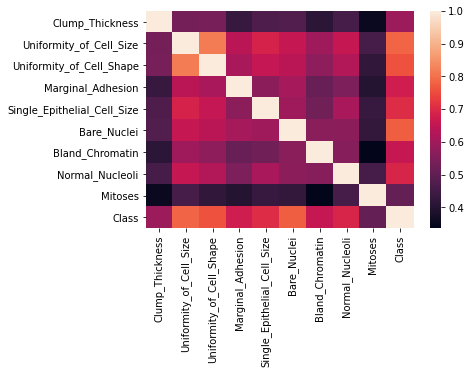

In [22]:
sns.heatmap(df.corr(method="kendall"));

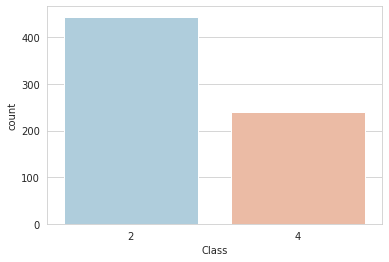

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='Class',data=df,palette='RdBu_r')

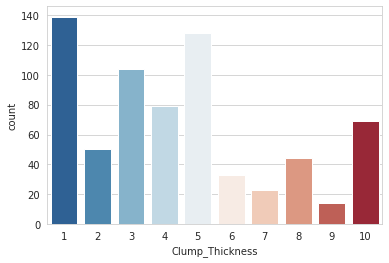

In [24]:
sns.set_style('whitegrid')
sns.countplot(x='Clump_Thickness',data=df,palette='RdBu_r')

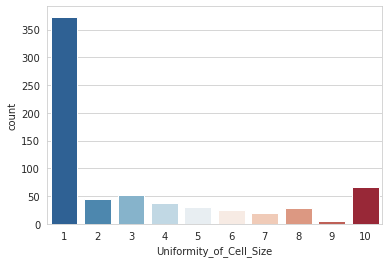

In [25]:
sns.set_style('whitegrid')
sns.countplot(x='Uniformity_of_Cell_Size',data=df,palette='RdBu_r')

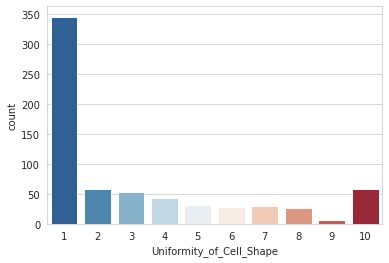

In [26]:
sns.set_style('whitegrid')
sns.countplot(x='Uniformity_of_Cell_Shape',data=df,palette='RdBu_r')


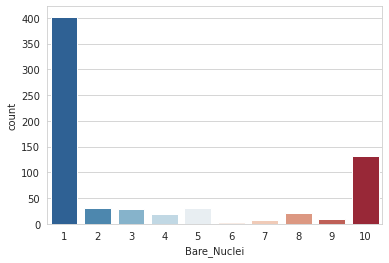

In [27]:
sns.set_style('whitegrid')
sns.countplot(x='Bare_Nuclei',data=df,palette='RdBu_r')

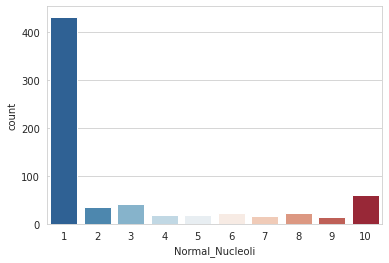

In [28]:
sns.set_style('whitegrid')
sns.countplot(x='Normal_Nucleoli',data=df,palette='RdBu_r')

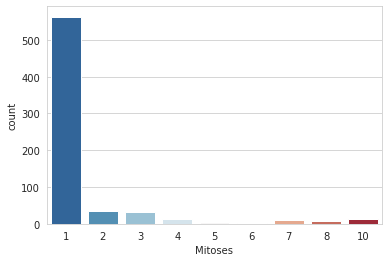

In [29]:
sns.set_style('whitegrid')
sns.countplot(x='Mitoses',data=df,palette='RdBu_r')


In [33]:
X, y = df.iloc[0:,0:9], df.iloc[:,9]

X=X.values
y=y.values

(N,D), C = X.shape, np.max(y)+1
#print(f'instances (N) \t {N} \n features (D) \t {D} \n classes (C) \t {C}')
#print(y.shape)

def custom_train_and_test_split(X, y):
    arrRand = np.random.rand(X.shape[0])
    custom_split = arrRand < np.percentile(arrRand, 70)

    X_train = X[custom_split]
    y_train = y[custom_split]
    X_test =  X[~custom_split]
    y_test = y[~custom_split]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = custom_train_and_test_split(X,y)
y_test_norm = (y_test-y_test.min())/(y_test.max()- y_test.min())

### Accuracy using Decision Tree (cost function - Misclassification)

In [48]:
for i in range(1, 30):
  tree = DecisionTree(max_depth=i, cost_fn=cost_misclassification)
  probs_test = tree.fit((X_train), y_train).predict(X_test)
  y_pred = np.argmax(probs_test,1)
  accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
  print("for" + str(i))
  print(f'accuracy is {accuracy*100:.1f}.')

for1
accuracy is 95.1.
for2
accuracy is 97.1.
for3
accuracy is 96.1.
for4
accuracy is 97.1.
for5
accuracy is 97.1.
for6
accuracy is 97.1.
for7
accuracy is 96.1.
for8
accuracy is 96.6.
for9
accuracy is 96.6.
for10
accuracy is 96.6.
for11
accuracy is 96.6.
for12
accuracy is 96.6.
for13
accuracy is 96.6.
for14
accuracy is 96.6.
for15
accuracy is 95.6.
for16
accuracy is 95.6.
for17
accuracy is 95.6.
for18
accuracy is 95.6.
for19
accuracy is 95.6.
for20
accuracy is 95.6.
for21
accuracy is 95.6.
for22
accuracy is 95.6.
for23
accuracy is 95.6.
for24
accuracy is 95.6.
for25
accuracy is 95.6.
for26
accuracy is 95.6.
for27
accuracy is 95.6.
for28
accuracy is 95.6.
for29
accuracy is 95.6.


In [50]:
tree = DecisionTree(max_depth=10, cost_fn=cost_misclassification)
tree.fit(X_train, y_train.astype(int))
predictions = tree.predict(X_test)

print("Confusion Matrix:")

print(confusion_matrix(y_test_norm, predictions[:,4].astype(int)))
print("Classification Report")
print(classification_report(y_test_norm, predictions[:,4].astype(int)))

Confusion Matrix:
[[136   3]
 [ 22  44]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92       139
         1.0       0.94      0.67      0.78        66

    accuracy                           0.88       205
   macro avg       0.90      0.82      0.85       205
weighted avg       0.89      0.88      0.87       205



### Accuracy using Decision Tree (cost function - Cost Entropy)

In [51]:
for i in range(1, 10):
  tree = DecisionTree(max_depth=i, cost_fn=cost_entropy)
  probs_test = tree.fit(X_train, y_train).predict(X_test)
  y_pred = np.argmax(probs_test,1)
  accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
  print("for" + str(i))
  print(f'accuracy is {accuracy*100:.1f}.')

for1
accuracy is 94.6.
for2
accuracy is 92.7.
for3
accuracy is 95.6.
for4
accuracy is 95.1.
for5
accuracy is 96.1.
for6
accuracy is 96.6.
for7
accuracy is 94.6.
for8
accuracy is 95.6.
for9
accuracy is 95.6.


In [52]:
tree = DecisionTree(max_depth=10, cost_fn=cost_entropy)
tree.fit(X_train, y_train.astype(int))
predictions = tree.predict(X_test)

print("Confusion Matrix:")

print(confusion_matrix(y_test_norm, predictions[:,4].astype(int)))
print("Classification Report")
print(classification_report(y_test_norm, predictions[:,4].astype(int)))

Confusion Matrix:
[[136   3]
 [  6  60]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       139
         1.0       0.95      0.91      0.93        66

    accuracy                           0.96       205
   macro avg       0.96      0.94      0.95       205
weighted avg       0.96      0.96      0.96       205



### Accuracy using Decision Tree (cost function - Gini Index)

In [53]:
for i in range(10, 20):
  tree = DecisionTree(max_depth=i, cost_fn=cost_gini_index)
  probs_test = tree.fit(X_train, y_train).predict(X_test)
  y_pred = np.argmax(probs_test,1)
  accuracy = np.sum(y_pred == y_test)/y_test.shape[0]
  print("for" + str(i))
  print(f'accuracy is {accuracy*100:.1f}.')

for10
accuracy is 94.1.
for11
accuracy is 94.1.
for12
accuracy is 94.1.
for13
accuracy is 94.1.
for14
accuracy is 94.1.
for15
accuracy is 94.1.
for16
accuracy is 94.1.
for17
accuracy is 94.1.
for18
accuracy is 94.1.
for19
accuracy is 94.1.


In [55]:
tree = DecisionTree(max_depth=10, cost_fn=cost_entropy)
tree.fit(X_train, y_train.astype(int))
predictions = tree.predict(X_test)

print("Confusion Matrix:")

print(confusion_matrix(y_test_norm, predictions[:,4].astype(int)))
print("Classification Report")
print(classification_report(y_test_norm, predictions[:,4].astype(int)))

Confusion Matrix:
[[136   3]
 [  6  60]]
Classification Report
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97       139
         1.0       0.95      0.91      0.93        66

    accuracy                           0.96       205
   macro avg       0.96      0.94      0.95       205
weighted avg       0.96      0.96      0.96       205



### Decision Boundary for Breast Cancer

next we fit the tree to the training data and predict on the test data. 

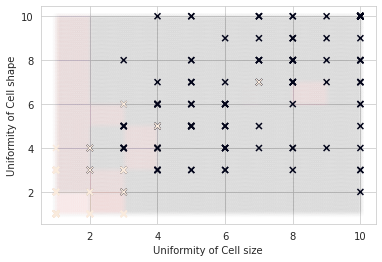

In [56]:
# print(X[:,1]) # Uniformity of cell size
# print(X[:,2]) # Uniformity of cell shape

x0v = np.linspace(np.min(X[:,1]), np.max(X[:,1]), 150)
x1v = np.linspace(np.min(X[:,2]), np.max(X[:,2]), 150)
x0,x1 = np.meshgrid(x0v, x1v)
x_all = np.vstack((x0.ravel(),x1.ravel())).T

model = DecisionTree(max_depth=10)

y_train_prob = np.zeros((y_train.shape[0], 2))

y_new=((y_train-y_train.min())/(y_train.max()-y_train.min())).astype(int)

y_train_prob[np.arange(y_new.shape[0]), y_new] = 1

X_train_new = X_train[:,[1,2]]

y_prob_all = model.fit(X_train_new, y_new).predict(x_all)

plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all[:,0], marker='o', alpha=.0091) 
plt.scatter(X_train_new[:,0], X_train_new[:,1],c=y_train_prob[:,0], marker='x', alpha = 1)
plt.xlabel('Uniformity of Cell size')
plt.ylabel('Uniformity of Cell shape')

plt.show()